# Phase 4 Project - NLP

This project is an academic exercise for Flatiron School's Data Science Phase 4 group project. From this point forward, we will treat this notebook as Data Scientists presenting to Apple Marketing Executives.

We walk through our modeling process for natural language processing to predict sentiment analysis of tweets, and then for academic purposes we further explore deployment of Meta's roBERTa TweetEval model. Enjoy!

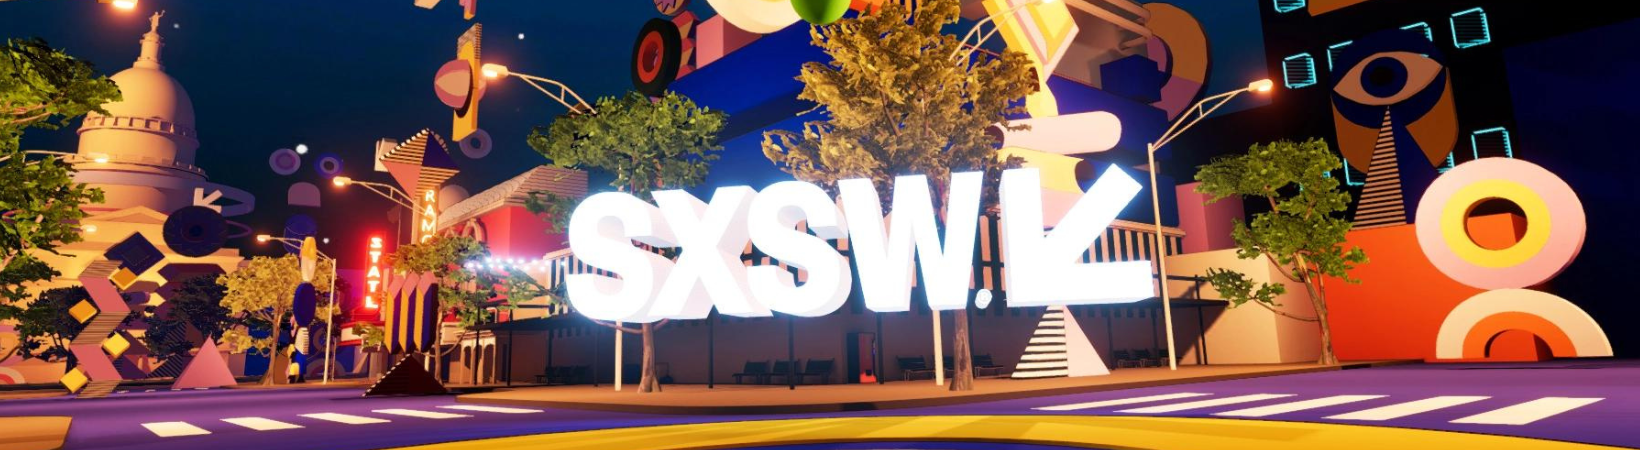

### Table of Contents

[Data Exploration](#Data-Exploration)

[Preprocessing](#Preprocessing)

[Baseline Model - Decision Tree Classifier](#Basline-Model---Decision-Tree-Classifier)

[Tuned Decision Tree](#Next-Model:-Tuned-Decision-Tree)

[Support Vector Machine Classifier](#Support-Vector-Machine-Classifier)

[Model Comparison](#Model-Comparison)

[Introducint roBERTa](#Introducing-roBERTa-TweetEval)

### Business Background

Days after the 2011 SXSW festival, we were tasked with analyzing the buzz generated by Apple's iPad 2 launch and general presence at the festival. Read more about SXSW [here](https://www.sxsw.com/about/).

In order to better understand the sentiment toward Apple and our products on Twitter, we set out to build a machine learning model that could be used to quickly analyze tweets and assign a sentiment.

### Data Understanding

The original data was slightly over 9,000 tweets from March 2011 during SXSW. From [CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions), "Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion."

**Data Cleaning**

We focused primarily on tweets that pertained directly to Apple and our offerings.

The dataset contains 3 columns:
- `tweet`: anonymized tweets containing truncated hyperlinks
- `directed`: a label indicating whether the tweet contains a sentiment towards a product or company in particular
    - Apple
    - Apple products
    - Google
    - Android
    - None
- `emotion`: an assigned label indicating the sentiment of the tweet
    - Positive
    - Neutral
    - Negative
    - Cant tell
    
On March 11th, the same day as the iPad 2 launch, there was a catostrophic earthquake in Japan. We considered this in our approach to data cleaning as it was common behavior to form a tweet about the crisis simultaneously hashtaging #sxsw or #ipad.

**Data Limitations**

You'll see that there were over 5000 missing values in the `directed` column. We were able to address this by imputing as many missing values as possible. The data set was also heavily imbalanced: overwhelmingly neutral with very few examples of negative sentiment.

We will use precision and accuracy as a metric in grading the models.


#### Import Necessary Libraries

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, words, wordnet
import string
nltk.download('words')
nltk.download('stopwords', quiet=True)
from nltk import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('tagsets')
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix, precision_score, classification_report
from sklearn import svm

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package words to
[nltk_data]     /Users/leahschell/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/leahschell/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/leahschell/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


## Data Exploration

In [36]:
df = pd.read_csv('data/tweets.csv', encoding='utf8')

In [37]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [38]:
# Option to view the whole tweet
#df.style.set_properties(**{'text-align': 'left'})

In [39]:
df.shape

(9093, 3)

The cell below shows that the target is imbalanced. 

In [40]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

We rename the columns for usability.

In [41]:
df.set_axis(['tweet', 'directed', 'emotion'], axis=1, inplace=True)

There was only one completely blank tweet! We will drop this row.

In [42]:
df.dropna(subset='tweet', axis=0, inplace=True)

There was a news headline from Japan during this time about an earthquake. So festival goers were tweeting about japan and hashtagging the SXSW event. We are removing these from the dataset, there were about 30.

In [43]:
df['tweet'].str.contains('japan').sum()
df = df.drop(df[df.apply(lambda row: row.astype(str).str.contains('japan').any(), axis=1)].index)
df.shape

(9068, 3)

We are solely focusing on Apple related tweets so this section removes the other brands. 

In [44]:
df['directed'].value_counts()

iPad                               944
Apple                              659
iPad or iPhone App                 468
Google                             429
iPhone                             297
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: directed, dtype: int64

In [45]:
df = df[(df['directed'] != 'Android App') & (df['directed'] != 'Android') & (df['directed'] != 'Google') & (df['directed'] != 'Other Google product or service')]

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

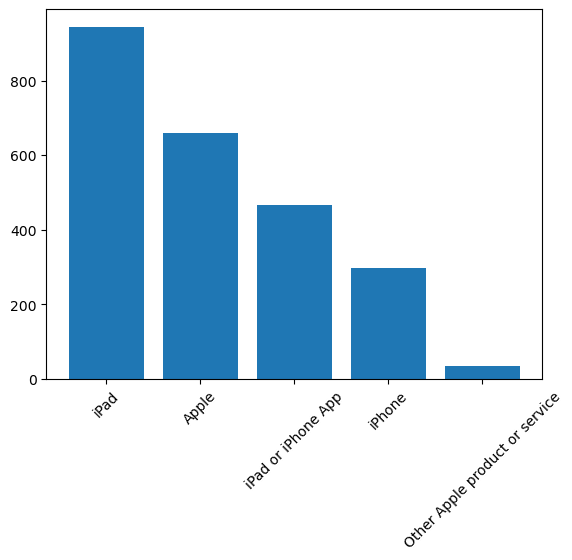

In [46]:
plt.bar(df['directed'].value_counts().index, df['directed'].value_counts().values)
plt.xticks(rotation=45)

This is technically a preprocessing step, however its going to help us with data cleaning moving forward. We will lower case the tweets here.

In [47]:
df['tweet'] = df['tweet'].str.lower()


The following section will impute the empty "Directed at" column. We can deduct from the tweet if they are referencing a particular brand or product. We created a dataframe that contains all the NaN "Directed at" rows. We iterated through ther tweets and fill in the "Directed at" column, then concatenate that to the original data. Had we dropped this section, we would have dropped about 5600 tweets. 

Create dataframe for only NaN values in Directed column

In [48]:
d_nan = df[(df['directed'].isna())]

Iterate through rows and fill the NaN values with a string from the tweet based on the product

In [49]:
for index, row in d_nan.iterrows():
    if 'apple' in str(row['tweet']):
        d_nan.at[index, 'directed'] = 'Apple'
    elif 'iphone' in str(row['tweet']):
        d_nan.at[index, 'directed'] = 'iPhone'
    elif 'ipad' in str(row['tweet']):
        d_nan.at[index, 'directed'] = 'iPad'
    elif 'steve jobs' in str(row['tweet']):
        d_nan.at[index, 'directed'] = 'Apple'
    elif 'stevejobs' in str(row['tweet']):
        d_nan.at[index, 'directed'] = 'Apple'
    else:
        pass

In [50]:
##Not all iterations located the string or it didnt exist

d_nan.isna().sum()

tweet          0
directed    2673
emotion        0
dtype: int64

In [51]:
#Dropping Nulls from the original dataframe
dfdrop = df.dropna(subset='directed', axis=0)

In [52]:
#Concat original dataframe with imputed dataframe
df_join = pd.concat([d_nan, dfdrop])

In [53]:
#Drop leftover missing values and rename to original dataframe name - 'df'
df = df_join.dropna(axis=0)

Encoding Emotion column for modeling

We also dropped out "I cant tell" from the emotion column. We are keep the neutral tweets, as we think buzz regarding the brand is still important. Or there are potential marketing opportunities to convert those neutrals to postives. 

In [54]:
df = df[(df['emotion'] != "I can't tell")]
df['emotion'].value_counts()

No emotion toward brand or product    2870
Positive emotion                      2128
Negative emotion                       418
Name: emotion, dtype: int64

In [55]:
emo_dict = {'No emotion toward brand or product': 1, 'Positive emotion': 2, 'Negative emotion': 0}
df['emotion'] = df['emotion'].map(emo_dict)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5416 entries, 5 to 9088
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet     5416 non-null   object
 1   directed  5416 non-null   object
 2   emotion   5416 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 169.2+ KB


### Final Dataframe

In [57]:
df.head()

,tweet,directed,emotion
5,@teachntech00 new ipad apps for #speechtherapy...,iPad,1
16,holler gram for ipad on the itunes app store -...,iPad,1
33,anyone at #sxsw want to sell their old ipad?,iPad,1
34,anyone at #sxsw who bought the new ipad want ...,iPad,1
37,spin play - a new concept in music discovery f...,iPad,1


## Preprocessing

This section outlines our preprocessing to prepare for modeling. We located frequent words to remove that are irelevant to the sentiment of the tweet (consider @mention, rt, link, sxsw). 

The preprocessing function takes in a document or tweet and does the following:
- Tokenize with RegExp
- Removes stopwords
- Gets the parts of speech for the lemmatizer
- Lemmatizes
- Removes the words from frequent word. We left this customizable and outside of the function so we can add words as we further come accross them. 

The preprocessing function returns the cleaned joined tweet, as vectorizers taken in full strings. 
This process will be outlined in more detail for this first model to view our thought process, then we streamline the process before each model along with the train-test-split.

In [58]:
#Remove words that are not relvant to the sentiment (@mentions, rt, links)
word_count = Counter()

for tweet in df['tweet']:
    tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
    tokenized = tokenizer.tokenize(tweet)
    for token in tokenized:
        word_count[token] += 1

In [59]:
#Expose common words

word_count.most_common()[:200]

[('sxsw', 5808),
 ('mention', 3916),
 ('the', 3065),
 ('ipad', 2464),
 ('link', 2301),
 ('apple', 2287),
 ('to', 2122),
 ('at', 1920),
 ('for', 1842),
 ('rt', 1677),
 ('iphone', 1535),
 ('in', 1441),
 ('store', 1436),
 ('up', 1098),
 ('is', 1067),
 ('and', 1021),
 ('of', 1021),
 ('on', 856),
 ('quot', 823),
 ('austin', 797),
 ('an', 767),
 ('it', 747),
 ('my', 679),
 ('you', 648),
 ('app', 638),
 ('pop', 581),
 ('with', 522),
 ('new', 500),
 ('ipad2', 459),
 ('amp', 452),
 ('just', 405),
 ('this', 387),
 ('line', 381),
 ('that', 351),
 ('be', 348),
 ('out', 328),
 ('your', 324),
 ('have', 322),
 ('by', 317),
 ('not', 307),
 ('are', 285),
 ('get', 273),
 ('from', 272),
 ('me', 266),
 ('now', 264),
 ('temporary', 263),
 ('one', 257),
 ('opening', 253),
 ('via', 241),
 ('if', 228),
 ('so', 227),
 ('can', 224),
 ('downtown', 217),
 ('will', 217),
 ('all', 211),
 ('popup', 208),
 ('or', 207),
 ('about', 204),
 ('they', 203),
 ('launch', 202),
 ('has', 201),
 ('free', 195),
 ('no', 194),
 ('

In [60]:
removewords = ['sxsw', 'mention', 'rt', 'quot', 'link', 'sxswi', 'ып', 'ыќ']

In [61]:
def preprocess(tweet):
    
    """
    Tokenize (also removes punctuation)
    Remove Stop words
    Lemmatize
    Remove frequent words
    Return joined string
    """
    
    
    tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
    tokenized = tokenizer.tokenize(tweet)
    
    stoplist = stopwords.words('english')
    tokenized_stopped = [x for x in tokenized if x not in stoplist]
    
    #get a clean part of speech tag for the lemmatizer
    def get_wordnet_pos(tweet):
        
        tagged_tweet = pos_tag(tweet)
        
        new_tags = []
        for word, tag in tagged_tweet:
            if tag.startswith('J'):
                tag = wordnet.ADJ
                new_tags.append([word, tag])
            elif tag.startswith('V'):
                tag = wordnet.VERB
                new_tags.append([word, tag])
            elif tag.startswith('N'):
                tag = wordnet.NOUN
                new_tags.append([word, tag])
            elif tag.startswith('R'):
                tag = wordnet.ADV
                new_tags.append([word, tag])
            else:
                tag = wordnet.NOUN
                new_tags.append([word, tag])
                
        
        return new_tags
    
    
    lem = WordNetLemmatizer()
    tagged_tweet = get_wordnet_pos(tokenized_stopped)
    tweet_lemmed = [lem.lemmatize(pair[0], pair[1]) for pair in tagged_tweet]
    
    #removewords is outside of the function
    tweet = [x for x in tweet_lemmed if x not in removewords]
    
    return " ".join(tweet)  #returns a clean joined tweet as a string

### TrainTestSplit

In [62]:
#assign X and y
X = pd.DataFrame(df['tweet'])
y = pd.DataFrame(df['emotion'])

#TrainTest Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Preprocess & Vectorize Train

In [63]:
#Instantiate vectorizer with 80 max features

tf = TfidfVectorizer(max_features=80)

In [64]:
#Apply preprocess function to the tweet column, return a new column to check that it works

X_train['tweet_clean'] = X_train['tweet'].apply(preprocess)

In [65]:
#Fit and transform Train set

X_train_vec = tf.fit_transform(X_train['tweet_clean'])

In [66]:
#Option to view it as a new dataframe. Converted from sparse matrix.

X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(tf.vocabulary_)
X_train_vec.head()

,6th,amp,android,anyone,app,apple,apps,austin,awesome,best,...,tweet,use,via,video,wait,want,win,work,would,year
0,0.000000,0.0,0.0,0.0,0.0,0.191114,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.463141,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.454324,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.194671,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.189549,0.0,0.289509,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.401955,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocess & Vectorize Test

In [67]:
#apply preprocess function defined above
X_test['tweet_clean'] = X_test['tweet'].apply(preprocess)

In [68]:
X_test_vec = tf.transform(X_test['tweet_clean'])

In [69]:
#Option to view it as a new dataframe. Converted from sparse matrix.

X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(tf.vocabulary_)
X_test_vec.head()

,6th,amp,android,anyone,app,apple,apps,austin,awesome,best,...,tweet,use,via,video,wait,want,win,work,would,year
0,0.0,0.0,0.0,0.000000,0.0,0.307479,0.0,0.469630,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.462208,0.0,0.178392,0.0,0.272468,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Basline Model - Decision Tree Classifier

For our baseline model, we chose a Decision Tree Classifier in order to get a better understanding of particular words that influence the data. This was helpful in analyzing whether we needed another round of preprocessing.

In [70]:
#instantiate
dt = DecisionTreeClassifier(max_depth=3, random_state=1)

In [71]:
dt.fit(X_train_vec, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

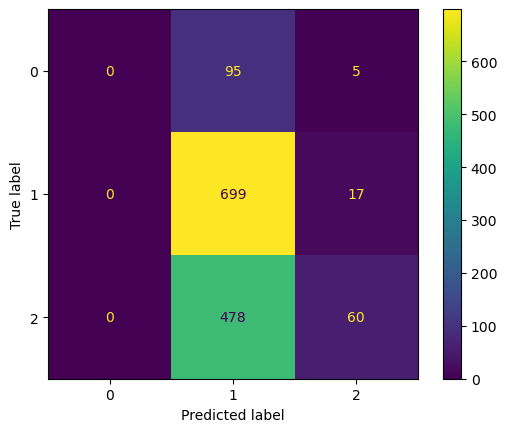

In [72]:
plot_confusion_matrix(dt, X_test_vec, y_test)

In [73]:
dt_test_score = dt.score(X_test_vec, y_test)
dt_test_score

0.5605612998522895

In [74]:
dt_train_score = dt.score(X_train_vec, y_train)
dt_train_score

0.5642540620384048

In [75]:
preds = dt.predict(X_test_vec)

In [76]:
dt_prec_score = precision_score(y_test, preds, average='weighted')
dt_prec_score

0.5813299857727542

In [77]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.55      0.98      0.70       716
           2       0.73      0.11      0.19       538

    accuracy                           0.56      1354
   macro avg       0.43      0.36      0.30      1354
weighted avg       0.58      0.56      0.45      1354



The following words had the most say in how the sentiment was determined:

In [78]:
features=X_train_vec.columns.tolist()
important = dt.feature_importances_
important_features = pd.DataFrame(important, index=features, columns=['Important'])
important_features.sort_values('Important', ascending=False).head(10)

,Important
cool,0.397189
awesome,0.278334
love,0.215628
time,0.040633
see,0.032087
first,0.021523
ipad,0.014606
open,0.000000
one,0.000000
party,0.000000


#### Interpretation

We still have some cleaning to remove words that don't offer any sentiment. Although the 58% precision score is not perfect, this is a good baseline to jump off of. It was great to see that the model was not overfit to the train set with accuracy at around 55-56% for both train and test. 

# Next Model: Tuned Decision Tree

After adjusting the words to remove, we will use a <b>Grid search</b> to find the best parameters. 

Add more words to remove, recall that they will actually be removed when we call the 'preprocess' function.

In [79]:
remove2 = ['amp', 'via', 'android', 'app', 'apps', 'apple', 'iphone', 'pop', 'store', 'photo', 'open']

In [80]:
for i in remove2:
    removewords.append(i)

In [81]:
removewords

['sxsw',
 'mention',
 'rt',
 'quot',
 'link',
 'sxswi',
 'ып',
 'ыќ',
 'amp',
 'via',
 'android',
 'app',
 'apps',
 'apple',
 'iphone',
 'pop',
 'store',
 'photo',
 'open']

### TrainTestSplit

Time to redo the train test split to prevent data leakage. We are also using unigrams and bigrams in this vectorizer and increased the amount of features. 

In [82]:
tf2 = TfidfVectorizer(max_features=200, ngram_range=(1,2))

In [83]:
X = pd.DataFrame(df['tweet'])
y = pd.DataFrame(df['emotion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [84]:
X_train['tweet_clean'] = X_train['tweet'].apply(preprocess)

In [85]:
X_train_vec = tf2.fit_transform(X_train['tweet_clean'])

In [86]:
X_test['tweet_clean'] = X_test['tweet'].apply(preprocess)

In [87]:
X_test_vec = tf2.transform(X_test['tweet_clean'])

### Modeling

In [88]:
dt2 = DecisionTreeClassifier(random_state=1)
param_grid = {'max_depth': range(2, 11),
             'min_samples_split': range(2,5)
             }

In [89]:
gs = GridSearchCV(dt2, param_grid)
gs.fit(X_train_vec, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': range(2, 11),
                         'min_samples_split': range(2, 5)})

In [90]:
gs.best_params_

{'max_depth': 9, 'min_samples_split': 2}

In [91]:
dt2 = DecisionTreeClassifier(max_depth=9, min_samples_split=2, random_state=1)

In [92]:
dt2.fit(X_train_vec, y_train)

DecisionTreeClassifier(max_depth=9, random_state=1)

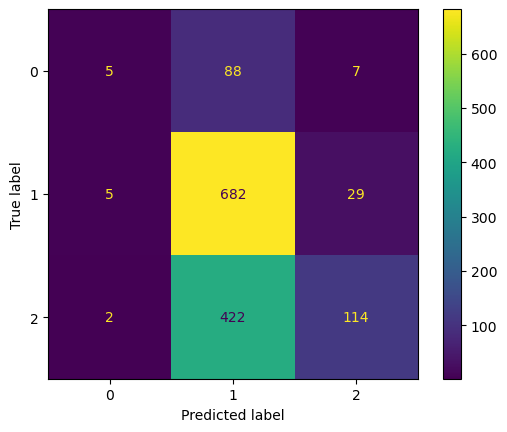

In [93]:
plot_confusion_matrix(dt2, X_test_vec, y_test)

In [94]:
dt2_train_score = dt2.score(X_train_vec, y_train)
dt2_train_score

0.603889709502708

In [95]:
dt2_test_score = dt2.score(X_test_vec, y_test)
dt2_test_score

0.5915805022156573

In [96]:
preds = dt2.predict(X_test_vec)

In [97]:
dt2_prec_score = precision_score(y_test, preds, average='weighted')
dt2_prec_score

0.6353060448947356

### Interpretation

We did see an improvement in this model by 7%! Precision was 63% and accuracy was around 60%. Another example of the decision tree not overfitting. The classification matrix looks slightly more distributed as well and less focused on neutral tweets, still room for improvement.

# Support Vector Machine Classifier

The use of this model is to address the class imbalance.

### Train Test Split & Preprocess

In [98]:
X = pd.DataFrame(df['tweet'])
y = pd.DataFrame(df['emotion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [99]:
#Vecorize and Preprocess Train and Test

tf4 = TfidfVectorizer(max_features=200, ngram_range=(1,2))
X_train['tweet_clean'] = X_train['tweet'].apply(preprocess)
X_train_vec = tf4.fit_transform(X_train['tweet_clean'])
X_test['tweet_clean'] = X_test['tweet'].apply(preprocess)
X_test_vec = tf4.transform(X_test['tweet_clean'])

### Modeling

In [100]:
#This will help balance the target classes that are currently imbalanced
sv = svm.SVC(class_weight='balanced')

sv.fit(X_train_vec, y_train)

SVC(class_weight='balanced')

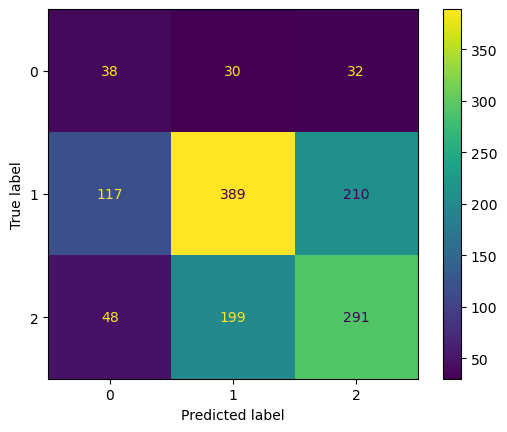

In [101]:
plot_confusion_matrix(sv, X_test_vec, y_test)

In [102]:
sv_test_score = sv.score(X_test_vec, y_test)

In [103]:
sv_train_score = sv.score(X_train_vec, y_train)

In [104]:
preds = sv.predict(X_test_vec)

In [105]:
sv_prec_score = precision_score(y_test, preds, average='weighted') #avergae parameter is mandatory for non-binary targets

### Interpretation

We used support vector machine classifier to help with the imbalance of the data. Some scores here did the best yet, however we wont use this model as its most prone to overfitting. The train score was 77% which was great to see but the test score was 56%. Precision score did about as well as our baseline at 57%. 

# Model Comparison

In [106]:
print("Baseline Model")
print(f"Train Score: {dt_train_score:.3f}, Test Score: {dt_test_score:.3f}, Precision: {dt_prec_score:.3f}\n")

print("Tuned Decision Tree")
print(f"Train Score: {dt2_train_score:.3f}, Test Score: {dt2_test_score:.3f}, Precision: {dt2_prec_score:.3f}\n")

print("SVC Model")
print(f"Train Score: {sv_train_score:.3f}, Test Score: {sv_test_score:.3f}, Precision: {sv_prec_score:.3f}")

Baseline Model
Train Score: 0.564, Test Score: 0.561, Precision: 0.581

Tuned Decision Tree
Train Score: 0.604, Test Score: 0.592, Precision: 0.635

SVC Model
Train Score: 0.751, Test Score: 0.530, Precision: 0.564


Our best performing model is the tuned decision tree. Given the size of the dataset, we wouldn't expect an extremely high score but we did see improvement in our models. The use of precision is to focus on reducing false positives.

### Next Steps

At present, we are very hesitant to base any future analysis on model that is only trained on 5000 tweets.

Should we choose to continue to invest in developing this model, we will need to collect vast amounts of data and explore data augmentation to produce more data in the minority class (negative tweets.) Data augmentation can be done in various ways, one interesting method is translating an English statement to Non-English, then back to English to get the same meaning but slightly different words.

However, we do need fast, reliable temperature checks available to our social media team in order to analyze twitter buzz in real time. For this reason, we have chosen to explore NLP models that are available to us.

# Introducing roBERTa TweetEval

[roBERTa](https://ai.facebook.com/blog/roberta-an-optimized-method-for-pretraining-self-supervised-nlp-systems/) is an NLP model developed by Meta's AI Team and introduced to the AI community in 2019. It expands on Google's BERT, pretrained on 3.3 Billion words ([Muller, 2022](https://huggingface.co/blog/bert-101)). 

One of the most useful functions of roBERTa is that it can predict sentiment in a tweet. First, we deployed the model on our original dataset using roBERTa's suggested minimal preprocessing. Next, we wondered if we could take our exploration a step further and preprocess the data a bit more to improve the results.

You can find a complete account of this exploration in [roBERTa.ipynb](./roBERTa.ipynb) located in this repository. Below we've distilled the results for readability as the roBERTa model does require a more advanced computational environment to run. 

In the following dataframe, you'll find: 
- `tweet`: the original text of the tweet
- `directed`: the brand or product to which sentiment is directed
- `original_score`: the original sentiment score assigned in the CrowdFlower dataset
- `roberta_pred`: predictions based on minimal preprocessing
- `final_roberta_pred`: predictiones based on expanded preproccesing

In [110]:
roberta = pd.read_csv('data/roberta.csv')
roberta = roberta.drop(['Unnamed: 0'], axis = 1)
roberta.head()

,tweet,directed,original_score,roberta_pred,final_roberta_pred
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0.0,0,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,2.0,2,2
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,2.0,2,2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0.0,1,1
4,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,2.0,2,2


In [119]:
def score(df):
    
    """
    Identify True Positives
    Identify False Positives
    Calculate Accuracy
    Calcualte Precision
    """
    
    
    #initialize scores
    roberta_truepos = 0
    final_roberta_truepos = 0
    roberta_falsepos = 0
    final_roberta_falsepos = 0
    
    #iterate over each row in the dataframe
    for index, row in df.iterrows():
        #true pos and false pos in roberta_pred
        if row['original_score'] == row['roberta_pred']:
            roberta_truepos +=1
        if row['original_score'] == 1 & row['roberta_pred'] == 0:
            roberta_falsepos += 1
        if row['original_score'] == 2 & row['roberta_pred'] == 0:
            roberta_falsepos += 1
        if row['original_score'] == 0 & row['roberta_pred'] == 1:
            roberta_falsepos += 1
        if row['original_score'] == 2 & row['roberta_pred'] == 1:
            roberta_falsepos += 1
        if row['original_score'] == 0 & row['roberta_pred'] == 2:
            roberta_falsepos += 1
        if row['original_score'] == 1 & row['roberta_pred'] == 2:
            roberta_falsepos += 1
            
        #true pos and false pos in final_roberta_pred
        if row['original_score'] == row['final_roberta_pred']:
            final_roberta_truepos += 1
        if row['original_score'] == 1 & row['final_roberta_pred'] == 0:
            final_roberta_falsepos += 1
        if row['original_score'] == 2 & row['final_roberta_pred'] == 0:
            final_roberta_falsepos += 1
        if row['original_score'] == 0 & row['final_roberta_pred'] == 1:
            final_roberta_falsepos += 1
        if row['original_score'] == 2 & row['final_roberta_pred'] == 1:
            final_roberta_falsepos += 1
        if row['original_score'] == 0 & row['final_roberta_pred'] == 2:
            final_roberta_falsepos += 1
        if row['original_score'] == 1 & row['final_roberta_pred'] == 2:
            final_roberta_falsepos += 1
    
    #accuracy score
    roberta_accuracy = roberta_truepos/len(df)
    final_roberta_accuracy = final_roberta_truepos/len(df)
    
    #precision
    roberta_precision = roberta_truepos/(roberta_truepos + roberta_falsepos)
    final_roberta_precision = final_roberta_truepos/(final_roberta_truepos + final_roberta_falsepos)
    
    return print(f"roBERTa Accuracy: {roberta_accuracy:.3f}\nroBERTa Precision: {roberta_precision:.3f}\nFinal roBERTa Accuracy: {final_roberta_accuracy:.3f}\nFinal roBERTa Precision: {final_roberta_precision:.3f}")

In [120]:
score(roberta)

roBERTa Accuracy: 0.735
roBERTa Precision: 0.756
Final roBERTa Accuracy: 0.710
Final roBERTa Precision: 0.760


We are very excited by roBERTa's performance, particularly in the vast improvement in precision scores. We find that when looking at the results, roBERTa's functionality does better account for the variety of sentiments represented in the dataset. It also scored better with tweets that contained more nuanced language like dry humor and sarcasm. We are also very optimistiv that the model's assessment of sentiment contains less bias.

# Conclusion and Looking Ahead

In conclusion, we are very pleased with the buzz generated by these last few weeks at SXSW.

Using roBERTa we will continue to expand beyond Twitter and look at other social platforms like Reddit, Pinterest, Facebook, Tumblr, Instagram, YouTube. There is so much data available and Machine Learning affords us the ability to analyze as much as possiblel in very little time.
